# AutoCNet
AutoCnet is a set of tools for generating, analyzing, and improving control networks of various sizes. In this tutorial, we will take a look at the basic components of AutoCNet and use it to analyze the initial Galileo Europa network.

## Imports

In [ ]:
# Required for autocnet imports
import os
os.environ['ISISROOT'] = '/usgs/cpkgs/anaconda3_linux/envs/isis4.2.0'
os.environ['PROJ_LIB'] = '/usgs/cpkgs/anaconda3_linux/envs/autocnet/share/proj'

# Autocnet Imports
from autocnet.graph.network import NetworkCandidateGraph
from autocnet.graph.edge import NetworkEdge
from autocnet.io.db.model import Matches, Points
from autocnet.transformation.roi import Roi
from autocnet.config_parser import parse_config

# Helpful Python Modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import getpass
from pathlib import Path

# Configuration
AutoCNet leverages services for cluster processing and data presistance that require configuration parameters to setup properly. For the cluster processing, AutoCNet uses a module called [redis](https://redis.io/) to create queues for the cluster jobs waiting to be dispatched to the cluster, a cluster for the computations, and conda environments activated during the cluster jobs to give the cluster access to the appropriate packages. Then for the database presistence AutoCNet uses a PostGIS database that requires spatial information.

In summary, AutoCNet needs configuration parameters for the following servives:
- redis
- cluster
- env (short for conda environment)
- database
- spatial

## Setting up the Configuration
You can configure AutoCNet with either a configuration file or a Python dictionary. If you are going to be doing continuing work on a network we recommend that you use a config file and treat it like the project file for your network. For this workshop, we're going to be using a dictionary because we can programmatically fill it in to ensure each participant has their own sand-box to work in.

The configuration parameters are typically held in a configuration yaml file. A configuration file has been compiled for use internal to the USGS ASC facilities leveraging a shared cluster and database. Use AutoCNet's function 'parse_config' to read in the yaml file and output a dictionary variable.

In [ ]:
# Grab our template config and parse it
template_config = '/scratch/jmapel/europa/config_template.yml'
config_dict = parse_config(template_config)

# Populate some fields with unique names using your username
uid = getpass.getuser()

# Setup directories on scratch to store data and logs
workshop_scratch = os.path.join('/scratch/jmapel/europa/workshop_scratch', uid)
workshop_logs = os.path.join(workshop_scratch, "logs")
workshop_temp = os.path.join(workshop_scratch, "temp")
Path(workshop_logs).mkdir(parents=True, exist_ok=True)
Path(workshop_temp).mkdir(parents=True, exist_ok=True)
config_dict["cluster"]["cluster_log_dir"] = workshop_logs
config_dict["cluster"]["tmp_scratch_dir"] = workshop_temp

# This is the name of your database
config_dict["database"]["name"] = f"{uid}_workshop_gal"
print("Your database is named", config_dict["database"]["name"])

# Setup redis queues to pass data to cluster jobs
config_dict["redis"]["basename"] = f'{uid}_workshop_gal'
config_dict["redis"]["completed_queue"] = f'{uid}_workshop_gal:done'
config_dict["redis"]["processing_queue"] = f'{uid}_workshop_gal:proc'
config_dict["redis"]["working_queue"] = f'{uid}_workshop_gal:working'

# The NetworkCandidateGraph
The core of AutoCNet is the NetworkCandidateGraph, or NCG, which represents all of the images and their relationships. As the name implies, the NCG is a graph structure where each image is a node and overlapping images have an edge between them. The NCG stores all of the control points and control measures in separate tables and associates them with corresponding images. The last component of the NCG is its spatial abilities. Because it is backed by a PostGIS database, each image, overlap region, and control point has a latitude, longitude geometry associated with it. These three components together allow for a broad range of control processing techniques.

## Setting up the NetworkCandidateGraph
The first step in creating a NetworkCandidateGraph is to create an object and configure it. This will setup the NCG with all of the information it needs to store and process the data we are going to load into it.

In [ ]:
ncg = NetworkCandidateGraph()
ncg.config_from_dict(config_dict)

## Loading image data
Now that our NetworkCandidateGraph is configured, we can load our Galileo images into it.

**NOTE: Be very careful re-running this cell as the clear_db=True parameter dumps all of the data out of your database if it already exists**

In [ ]:
galileo_list = '/scratch/jmapel/europa/original_cubes.lis'
ncg.add_from_filelist(galileo_list, clear_db=True)

We can now look at our NCG and see the relationships between the images

In [ ]:
ncg.plot()
plt.show()

### Exercise: What do you notice about the graph structure? Why does the graph look that way?

## PGAdmin

Let's take a look at our NCG's database. You can view all of the data in our NCG on PGAdmin at [autocnet.wr.usgs.gov](https://autocnet.wr.usgs.gov).

## Loading control data

If we were generating a network from scratch, we would use some of AutoCNets image matching and spatial tools to pick control points and control measures. We'll see that process in the next workshop, for now we're just going to load in the data from the existing ISIS control network.

In [ ]:
galileo_net = '/scratch/jmapel/europa/networks/GLL_FFCombined_thin_SubReg2_Del_2.net'
ncg.place_points_from_cnet(galileo_net)

### Exercise: Go on PGAdmin and look at what tables are populated in the database and what tables are not populated.

## In the future
The steps we went through here are neatly combined into a single function and generally that's what you will use to create a NCG from a list of images and an ISIS control network.

In [ ]:
?NetworkCandidateGraph.from_cnet

You can also reload an existing database into a NCG once it has been configured to point to the database.

In [ ]:
?NetworkCandidateGraph.from_database

# Getting the pairwise image matches
All of our control data is now loaded into out NCG and we can start working with it. In this notebook we will be using pairwise compute vision techniques to look for bad control measures.

The first process we need to do is collect all of the pairwise matches between images. Our control network currently contains control points and all of the measurements of them. We need to convert these multi-image relationships into all of the common points between each pair of images.

To do this, we're going to use Autocnet's apply function to run parallel processing on each edge of the NetworkCandidateGraph

In [ ]:
?NetworkCandidateGraph.apply

### SLURM parameters
These parameters will be used when creating SLURM jobs for cluster processing via the apply function. Depending on the complexity of the jobs you are running, you may want to change the walltime and arraychunk parameters.

In [ ]:
walltime="00:30:00"
arraychunk=75
chunksize=16723

# make a new directory for just our matching logs
match_log_dir = os.path.join(workshop_logs, "match")
Path(match_log_dir).mkdir(parents=True, exist_ok=True)

## Convert control measures and points to image matches
This cell uses apply to run the network_to_matches function on each edge. It is very important that this function only get run once per edge or it will add duplicate matches. So, this cell also contains a check that skips the function if the database already has matches in it.

In [ ]:
?NetworkEdge.network_to_matches

In [ ]:
with ncg.session_scope() as session:
    num_matches = session.query(Matches).count()
if num_matches == 0:
    print("Loading matches table")
    njobs = ncg.apply('network_to_matches', 
                      on='edges',
                      # SLURM kwargs
                      walltime=walltime,
                      log_dir=match_log_dir,
                      arraychunk=arraychunk,
                      chunksize=chunksize)
    print(f'Started {njobs} jobs')
else:
    print("Matches table already populated")

### Looking at running cluster jobs with SLURM
Our cell has completed running in our notebook, but the jobs on the cluster have not finished yet. So, let's take a look at the what SLURM says is running for us.

In [ ]:
!squeue -u $uid

# Outlier Detection

## Homographies and Reprojective Error
The first computer vision technique that we will apply is called a homography. A homography is a transformation between two planes. In the contect of multi-view imagery, a homography is used when two images observe the same planar surface.

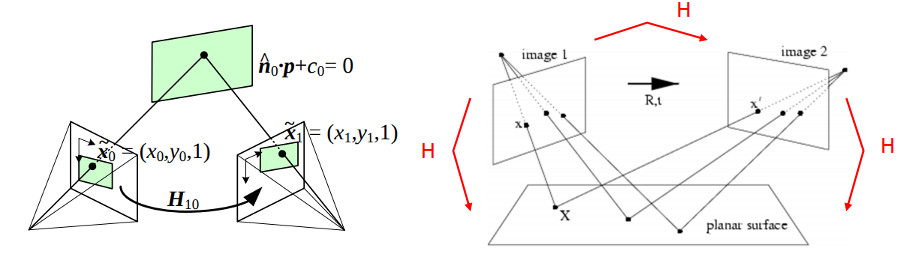

If we can identify points on a planar surface in two images, then we can compute a homography that transforms how the planar surface appears in one image into how the planar surface appears in the other image. Assuming that our surface is roughly planar, we can use our image to image matches to approximate a homography. Then, we can take a measure in one image and transform it into the matching image. Finally, we compare the transformed measure location to the actual measure location and if they vary sufficiently that match is likely incorrect.

In [ ]:
?NetworkEdge.compute_homography

## The Fundamental Matrix
The next computer vision technique we will apply is called the fundamental matrix. Similar to a homography, the fundamental matrix describes the relationship between two images that are observing the same thing. Unlike a homography, though, the fundamental matrix does not assume that the two images are observing a planar surface. Instead, the fundamental matrix describes the epipolar geometry between the two images. In short, the epipolar geometry is what lines and points are visible in one image, but occluded in the other.

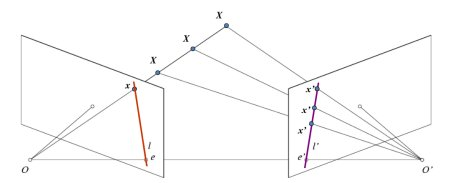

$x = (line, sample, 1)$ is the measure in image A

$x^{'} = (line, sample, 1)$ is the measure in image B

$F \in \mathbb{R}^{3\times3}$ is the Fundamental matrix for images A and B

$x^{T}Fx^{'} = 0$

This geometry is another relationship between matching measures that we can use to find potentially bad matches. Unlike a homography, the fundamental matrix is unique for a pair of images. So, we can compute a fundamental matrix for the image pair and then check that all of the matching measures satisfy the fundamental matrix relationship. Because the fundamental matrix describes the 3D relationship between the images, we need more data to compute it. At a minimum we need 8 matches to compute the fundamental matrix, but for robustness, we want at least 16.

In [ ]:
?NetworkEdge.compute_fundamental_matrix

## Running the outlier checks
Now that we know what we're doing, let's run the outlier checks on our network. Because we have over 100,000 matches on around 5,000 edges to process, we're going to again dispatch this work to the cluster.

Just like before we're going to use apply, but this time we're going to pass parameters to the functions we're applying. In both functions we will use ransac try and mitigate the effects of the outliers. For the fundamental matrix we'll pass a tolerance of 3 pixels and for the homography we'll pass a tolerance of 5 pixels.

In [ ]:
# make a new directory for just our fundamental logs
# the other SLURM parameters will stay the same
fundamental_log_dir = os.path.join(workshop_logs, "fundamental")
Path(fundamental_log_dir).mkdir(parents=True, exist_ok=True)

njobs = ncg.apply('compute_fundamental_matrix', 
                  on='edges',
                  # homography kwargs
                  method='ransac',
                  reproj_threshold=3,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=fundamental_log_dir,
                  arraychunk=arraychunk,
                  chunksize=chunksize)

print(f'Starting {njobs} fundamental matrix checks')
print(f'Logs are located at {fundamental_log_dir}')

In [ ]:
# make a new directory for just our fundamental logs
# the other SLURM parameters will stay the same
homography_log_dir = os.path.join(workshop_logs, "homography")
Path(homography_log_dir).mkdir(parents=True, exist_ok=True)

njobs = ncg.apply('compute_homography', 
                  on='edges',
                  # fundamental matrix kwargs
                  method='ransac',
                  reproj_threshold=5,
                  # SLURM kwargs
                  walltime=walltime,
                  log_dir=homography_log_dir,
                  arraychunk=arraychunk,
                  chunksize=chunksize)

print(f'Starting {njobs} homography checks')
print(f'Logs are located at {homography_log_dir}')

### Tracking running cluster jobs with REDIS

You can also check the queue_length property on the NetworkCandidateGraph object to see how many jobs are either waiting to be processed or in process. This property is how many jobs are waiting in your REDIS job queue.

In [ ]:
# Import some things to make a more active tracker
import time
from IPython.display import display, clear_output

while (ncg.queue_length > 0):
    clear_output(wait=True)
    display(ncg.queue_length,)
    time.sleep(1)

## Looking at the results
The outlier checks add a property to each edge called masks. This is a Pandas dataframe that contains a column for each check that has been done on the edge. If the row for a match has a true in it, then that match passed the column's check. Conversely, if the row for a match has a false in it, then that match failed the column's check. We will aggregate this data into a dataframe to get an overview of our results.

In [ ]:
match_data = {
    "source": [],
    "dest": [],
    "matches": [],
    "homography": [],
    "fundamental": []
}
for source, dest, edge in ncg.edges(data="data"):
    num_matches = len(edge.matches)
    # Edges with few matches are more likely to be skewed by outliers so only take edges with 20+ matches
    if num_matches < 20:
        continue
    match_data["source"].append(source)
    match_data["dest"].append(dest)
    match_data["matches"].append(num_matches)
    match_data["homography"].append(sum(edge.masks['homography']))
    match_data["fundamental"].append(sum(edge.masks['fundamental']))

In [ ]:
match_df = pd.DataFrame(data=match_data)
match_df.describe()

It's somewhat difficult to compare edges when they all have different numbers of matches, so let's compute the pass rates and sort the edges from worst to best.

In [ ]:
match_df["homography_percent"] = match_df["homography"] / match_df["matches"]
match_df["fundamental_percent"] = match_df["fundamental"] / match_df["matches"]
match_df[["homography_percent","fundamental_percent"]]
match_df.sort_values(["fundamental_percent", "homography_percent"]).head(50)

### Viewing Nodes
In the matches data you'll notice that the "source" and "dest" columns have just numbers in them instead of image paths or serial numbers. This is because of how AutoCNet stores images in the NetworkCandidateGraph. Each image is stored on a node identified by its image id. We can get things like the path to the image and the image's serial number using the node-view of the NCG.

In [ ]:
image_1 = ncg.nodes[1]['data'] # Note that we need to access the node data here
print(image_1['image_path'])
print(image_1.isis_serial)

### Viewing Edges
Similar to the nodes, edges in our NCG are identified by IDs. Each edge is identified by the IDs of the nodes it connects. You can access the nodes in our NCG using the get_edge_data method.

In [ ]:
?NetworkCandidateGraph.get_edge_data

In [ ]:
edge_1_2 = ncg.get_edge_data(1, 2)['data'] # Note the data again

Once you have an edge, you can do things like compute the overlap between the two images or generate matched. In this case we will be looking at the matches from our control network.

In [ ]:
# There are a lot of columns in the matches dataframe so we'll make a list of just the ones we want
match_columns = ["point_id", "source_measure_id", "destin_measure_id", "source_x", "source_y", "destination_x", "destination_y"]
edge_1_2.matches[match_columns]

You can also filter the matches using the edge's mask.

The cell below will show us all of the matches that passed the fundamental matrix check

In [ ]:
edge_1_2.matches.loc[edge_1_2.masks['fundamental'], match_columns]

This next cell will show us all of the matches that failed the fundamental matrix check

In [ ]:
edge_1_2.matches.loc[~edge_1_2.masks['fundamental'], match_columns] # Note the ~ to negate the fundamental mask

### Exercise: Pick an edge from our matches_df that has some homography failures and find the matches that failed.
Use the code fragment in the cell below and replace the `___` with the approriate things

In [ ]:
failed_edge = ncg.get_edge_data( ___ , ___ )['data']
failed_edge.matches.loc[~failed_edge.masks[ ___ ], match_columns]

## Viewing Matches
Listing the match data is nice, but it's hard to do anything with just that. So, let's look at the actual matches between images.

First we're going to pick an edge. In this case we'll be looking at edge 110, 33

In [ ]:
viewing_edge = ncg.get_edge_data(110, 33)['data']

We're going to look at three different sets of matches:

1. The matches that failed the homography check
1. The matches that failed the fundamental matrix check
1. The matches that failed both checks
1. The matches that failed either check

The code for the first two is exactly like how we viewed the matches on edge 1,2. The code for the last two sets is a little more complicated and will use the all and any functions which allow you to combine multiple masks into a single mask.

In [ ]:
?pd.DataFrame.all

In [ ]:
?pd.DataFrame.any

In [ ]:
failed_homography = viewing_edge.matches.loc[(~viewing_edge.masks['homography'])]
failed_fundamental = viewing_edge.matches.loc[(~viewing_edge.masks['fundamental'])]
failed_both = viewing_edge.matches.loc[(~viewing_edge.masks[['fundamental', 'homography']]).all(axis=1)]
failed_either = viewing_edge.matches.loc[(~viewing_edge.masks[['fundamental', 'homography']]).any(axis=1)]
print(f'{len(failed_homography)} matches failed the homography check')
print(f'{len(failed_fundamental)} matches failed the fundamental matrix check')
print(f'{len(failed_both)} matches failed both checks')
print(f'{len(failed_either)} matches failed a checks')

It looks like for our particular edge, there are no matches that failed both checks. That's okay it's still worth looking at these failed matches. The next cell will take each match and show us what point it is from and a small chip around the failed measures.

In [ ]:
roi_size = 25
for idx, match in failed_either.iterrows():
    with ncg.session_scope() as session:
        point_name = session.query(Points).filter(Points.id == match["point_id"]).first().identifier

    source_image = ncg.nodes[match['source']]['data']
    dest_image = ncg.nodes[match['destination']]['data']
    source_roi = Roi(source_image.geodata, match['source_x'], match['source_y'], size_x=roi_size, size_y=roi_size)
    dest_roi = Roi(dest_image.geodata, match['destination_x'], match['destination_y'], size_x=roi_size, size_y=roi_size)

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(point_name)
    ax1.imshow(source_roi.array, cmap='gray')
    ax1.plot(source_roi.center[0] + source_roi.axr, source_roi.center[1] + source_roi.ayr, 'ro')
    ax1.title.set_text(os.path.split(source_image['image_name'])[-1])
    ax2.imshow(dest_roi.array, cmap='gray')
    ax2.plot(dest_roi.center[0] + dest_roi.axr, dest_roi.center[1] + dest_roi.ayr, 'bo')
    ax2.title.set_text(os.path.split(dest_image['image_name'])[-1])
    fig.show()

### Exercise: Pick a different edge that had failures on it and look at some of the failed match sets
You can change viewing_edge and then re-run the last two cells to do this.

In [ ]:
viewing_edge = ncg.get_edge_data( ___ , ___ )['data']